<a href="https://colab.research.google.com/github/tonigarrett2023/FinalProject/blob/main/Resnet50_class_balanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import the necessary packages

import numpy as np
import tensorflow as tf

from keras.optimizers import SGD
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,BatchNormalization, AveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import label_binarize

import os
import pandas as pd
import glob
import time
import random
import cv2

import torch
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.utils.data import DataLoader

In [ ]:

from google.colab import drive
drive.mount('/content/drive/')



Mounted at /content/drive/


In [ ]:
# Define paths for the two datasets where dataset1 is Hyperkvasir and dataset2 is CrohnIPI
dataset1_path = "/content/drive/MyDrive/Final_Project/Hyperkvasir_labeled_images/upper_lower_gi_tract"
dataset1_csv = "/content/drive/MyDrive/Final_Project/Hyperkvasir_labeled_images/image-labels.csv"

dataset2_path = '/content/drive/MyDrive/Final_Project/DataCrohnIPI/imgs'
dataset2_csv = '/content/drive/MyDrive/Final_Project/DataCrohnIPI/CrohnIPI_description.csv'

# Define constants for merged datasets
data_dir = '/content/drive/MyDrive/Final_Project/merged_dir'

In [ ]:
# Create separate datasets for the following:
train_dir = os.path.join(data_dir, 'training_dataset')
val_dir = os.path.join(data_dir, 'validation_dataset')
test_dir = os.path.join(data_dir, 'testing_dataset')


### Define data transforms dictionary which will contain the image transformations for the training and validation datasets. Also define the threshold for determining which classes are under represented 

In [ ]:
# Define threshold for under represented data class for augmentation 
threshold = 5

In [ ]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Load the datasets and create DataLoader objects for training, val and testing datasets. The DataLoader objects handle shuffling and parallel loading of the data


In [ ]:

train_dataset = datasets.ImageFolder(train_dir, transform = data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform = data_transforms['val'])
test_dataset = datasets.ImageFolder(test_dir, transform = data_transforms['val'])

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
dataloaders = {'train': train_dataloader, 'val': val_dataloader}

### Define the device (CPU or GPU) for the training, loads the pretrained ResNet50 model and modify the final layer by freezing its parameters. The final layer is set to match the number of classes and moves the model to the device. 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
for param in model.parameters():
  param.requires_grad=False

In [ ]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

In [ ]:
model = model.to(device)

### Define the cross entropy loss function and the Stochastic Gradient Descent (SGD) optimizer with learning rate 0.001 and momentum of 0.9 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

### Train the model for 25 epochs. 

The training loop goes through the training and validation datasets, computes the loss, updates the model parameters in the training phase and prints out the loss and accuracy for each epoch. 

In [ ]:
# Train the model
num_epochs = 25

for epoch in range(num_epochs):
  print('Epoch {}/{}'.format(epoch, num_epochs -1))
  print('-' * 10)

  for phase in ['train', 'val']:
    if phase == 'train':
      model.train()
    else: 
      model.eval()

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloaders[phase]:
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      with torch.set_grad_enabled(phase == 'train'):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        if phase == 'train':
          loss.backward()
          optimizer.step()

      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloaders[phase].dataset)
    epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
  print()

print('Training complete')

Epoch 0/24
----------
train Loss: 1.1140 Acc: 0.6892
val Loss: 0.8158 Acc: 0.7672

Epoch 1/24
----------
train Loss: 0.9862 Acc: 0.7109
val Loss: 0.7397 Acc: 0.7705

Epoch 2/24
----------
train Loss: 0.9095 Acc: 0.7260
val Loss: 0.6918 Acc: 0.7903

Epoch 3/24
----------
train Loss: 0.8848 Acc: 0.7273
val Loss: 0.6907 Acc: 0.7842

Epoch 4/24
----------
train Loss: 0.8503 Acc: 0.7373
val Loss: 0.6594 Acc: 0.7870

Epoch 5/24
----------
train Loss: 0.8376 Acc: 0.7367
val Loss: 0.6426 Acc: 0.7988

Epoch 6/24
----------
train Loss: 0.8082 Acc: 0.7490
val Loss: 0.6254 Acc: 0.8101

Epoch 7/24
----------
train Loss: 0.7999 Acc: 0.7445
val Loss: 0.6083 Acc: 0.8063

Epoch 8/24
----------
train Loss: 0.7848 Acc: 0.7512
val Loss: 0.6327 Acc: 0.8021

Epoch 9/24
----------
train Loss: 0.7574 Acc: 0.7598
val Loss: 0.6313 Acc: 0.7955

Epoch 10/24
----------
train Loss: 0.7665 Acc: 0.7551
val Loss: 0.6207 Acc: 0.8025

Epoch 11/24
----------
train Loss: 0.7545 Acc: 0.7572
val Loss: 0.5896 Acc: 0.8200

Ep

In [ ]:
model_save_path = "/content/drive/MyDrive/Final_Project/Models/resnet50_trained.pth"
torch.save(model.state_dict(), model_save_path)
print("Model saved to", model_save_path)


Model saved to /content/drive/MyDrive/Final_Project/Models/resnet50_trained.pth


# EVALUATIONS 

In [ ]:
# Set the model to evaluation mode
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Function to get predictions for a batch of images
def get_predictions(model, data_loader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)


In [ ]:
# Get predictions for the test dataset
test_preds, test_labels = get_predictions(model, test_dataloader)

Confusion Matrix:


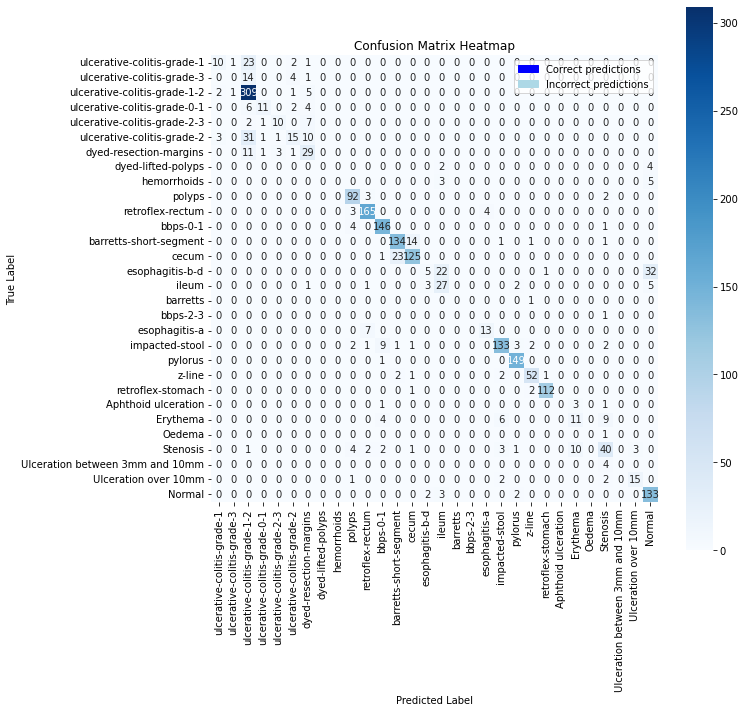

In [ ]:
# Calculate and print confusion matrix
cm = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:")
#print(cm)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, cbar=True, cbar_kws={'orientation': 'vertical'},
            xticklabels=['ulcerative-colitis-grade-1', 'ulcerative-colitis-grade-3', 'ulcerative-colitis-grade-1-2', 'ulcerative-colitis-grade-0-1',
               'ulcerative-colitis-grade-2-3', 'ulcerative-colitis-grade-2', 'dyed-resection-margins', 'dyed-lifted-polyps',
               'hemorrhoids', 'polyps', 'retroflex-rectum', 'bbps-0-1', 'barretts-short-segment', 'cecum',
               'esophagitis-b-d', 'ileum', 'barretts', 'bbps-2-3', 'esophagitis-a', 'impacted-stool', 'pylorus',
               'z-line', 'retroflex-stomach', 'Aphthoid ulceration', 'Erythema', 'Oedema', 'Stenosis',
               'Ulceration between 3mm and 10mm', 'Ulceration over 10mm', 'Normal'], 
            yticklabels=['ulcerative-colitis-grade-1', 'ulcerative-colitis-grade-3', 'ulcerative-colitis-grade-1-2', 'ulcerative-colitis-grade-0-1',
               'ulcerative-colitis-grade-2-3', 'ulcerative-colitis-grade-2', 'dyed-resection-margins', 'dyed-lifted-polyps',
               'hemorrhoids', 'polyps', 'retroflex-rectum', 'bbps-0-1', 'barretts-short-segment', 'cecum',
               'esophagitis-b-d', 'ileum', 'barretts', 'bbps-2-3', 'esophagitis-a', 'impacted-stool', 'pylorus',
               'z-line', 'retroflex-stomach', 'Aphthoid ulceration', 'Erythema', 'Oedema', 'Stenosis',
               'Ulceration between 3mm and 10mm', 'Ulceration over 10mm', 'Normal']) 
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')

# Create custom legend
blue_patch = mpatches.Patch(color='blue', label='Correct predictions')
light_blue_patch = mpatches.Patch(color='lightblue', label='Incorrect predictions')
plt.legend(handles=[blue_patch, light_blue_patch], loc='upper right')

plt.show()

In [ ]:
class_names = ['ulcerative-colitis-grade-1', 'ulcerative-colitis-grade-3', 'ulcerative-colitis-grade-1-2', 'ulcerative-colitis-grade-0-1',
               'ulcerative-colitis-grade-2-3', 'ulcerative-colitis-grade-2', 'dyed-resection-margins', 'dyed-lifted-polyps',
               'hemorrhoids', 'polyps', 'retroflex-rectum', 'bbps-0-1', 'barretts-short-segment', 'cecum',
               'esophagitis-b-d', 'ileum', 'barretts', 'bbps-2-3', 'esophagitis-a', 'impacted-stool', 'pylorus',
               'z-line', 'retroflex-stomach', 'Aphthoid ulceration', 'Erythema', 'Oedema', 'Stenosis',
               'Ulceration between 3mm and 10mm', 'Ulceration over 10mm', 'Normal']

# Calculate and print classification report
cr = classification_report(test_labels, test_preds, target_names=class_names)
print("Classification Report:")
print(cr)

Classification Report:
                                 precision    recall  f1-score   support

     ulcerative-colitis-grade-1       0.67      0.27      0.38        37
     ulcerative-colitis-grade-3       0.00      0.00      0.00        19
   ulcerative-colitis-grade-1-2       0.78      0.97      0.86       318
   ulcerative-colitis-grade-0-1       0.79      0.48      0.59        23
   ulcerative-colitis-grade-2-3       0.71      0.50      0.59        20
     ulcerative-colitis-grade-2       0.60      0.25      0.35        61
         dyed-resection-margins       0.50      0.64      0.56        45
             dyed-lifted-polyps       0.00      0.00      0.00         6
                    hemorrhoids       0.00      0.00      0.00         8
                         polyps       0.87      0.95      0.91        97
               retroflex-rectum       0.92      0.96      0.94       172
                       bbps-0-1       0.89      0.97      0.93       151
         barretts-short-seg

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Calculate and print accuracy score
acc = accuracy_score(test_labels, test_preds)
print("Accuracy Score: {:.2f}".format(acc))

Accuracy Score: 0.82


## calculate the macro-average ROC AUC score and weighted F1 score 

In [ ]:
# Binarize the labels
n_classes = len(class_names)
test_labels_bin = label_binarize(test_labels, classes=range(n_classes))



In [ ]:
batch_size = 32

# Calculate probabilities for each class
test_probs = np.zeros((len(test_labels), n_classes))
for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
    test_probs[i * batch_size:(i + 1) * batch_size] = probs

In [ ]:
# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

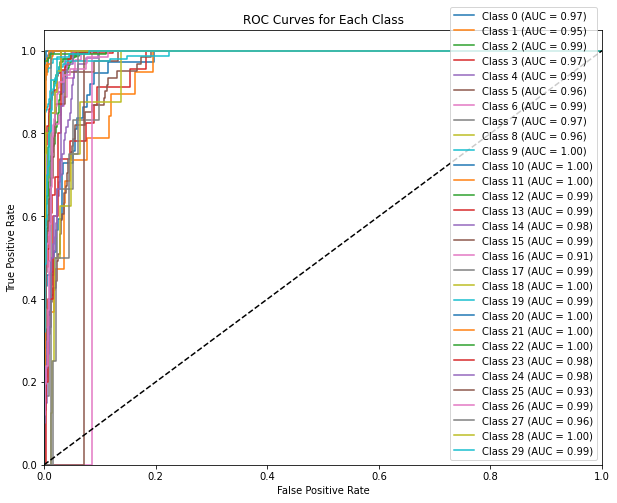

In [ ]:

# Visualize the ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Compute macro-average ROC AUC
roc_auc_macro = roc_auc_score(test_labels_bin, test_probs, average='macro')
print("Macro-average ROC AUC score: {:.2f}".format(roc_auc_macro))

Macro-average ROC AUC score: 0.98


In [ ]:
# Calculate and print weighted F1 score
f1_weighted = f1_score(test_labels, test_preds, average='weighted')
print("Weighted F1 score: {:.2f}".format(f1_weighted))

Weighted F1 score: 0.79


# Further training 

Loading a pre-trained model and continuing training for more epochs can potentially improve the performance of the model. This is because the pre-trained model already has learned features from a large dataset, and fine-tuning it on a smaller dataset can help it to learn more specific features related to the task at hand.

Additionally, by using early stopping, we can prevent the model from overfitting the training data by stopping the training process when the validation loss stops improving. This can help to improve the generalization performance of the model on new, unseen data.

However, it is important to monitor the training process closely to ensure that the model is not overfitting to the training data.

In [ ]:
num_classes = len(class_names)

# To load the saved model
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Freeze the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# Set requires_grad=True only for the new layers
for param in model.fc.parameters():
    param.requires_grad = True

In [ ]:
model.load_state_dict(torch.load(model_save_path))
model.eval()  # Set the model to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Train the model for more epochs with early stopping
best_acc = 0.0
patience = 5
early_stop_counter = 0

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # Early stopping
        if phase == 'val':
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= patience:
                print('Validation accuracy did not improve for {} epochs. Stopping early.'.format(patience))
                break

print('Training complete')

Epoch 0/24
----------
train Loss: 0.6903 Acc: 0.7720
val Loss: 0.5829 Acc: 0.8025
Epoch 1/24
----------
train Loss: 0.6816 Acc: 0.7729
val Loss: 0.5606 Acc: 0.8214
Epoch 2/24
----------
train Loss: 0.6729 Acc: 0.7772
val Loss: 0.5653 Acc: 0.8167
Epoch 3/24
----------
train Loss: 0.6918 Acc: 0.7720
val Loss: 0.5623 Acc: 0.8134
Epoch 4/24
----------
train Loss: 0.6772 Acc: 0.7766
val Loss: 0.5589 Acc: 0.8157
Epoch 5/24
----------
train Loss: 0.6728 Acc: 0.7800
val Loss: 0.5577 Acc: 0.8209
Epoch 6/24
----------
train Loss: 0.6651 Acc: 0.7786
val Loss: 0.5503 Acc: 0.8134
Validation accuracy did not improve for 5 epochs. Stopping early.
Epoch 7/24
----------
train Loss: 0.6624 Acc: 0.7815
val Loss: 0.5603 Acc: 0.8223
Epoch 8/24
----------
train Loss: 0.6639 Acc: 0.7803
val Loss: 0.5532 Acc: 0.8176
Epoch 9/24
----------
train Loss: 0.6672 Acc: 0.7765
val Loss: 0.5586 Acc: 0.8214
Epoch 10/24
----------
train Loss: 0.6777 Acc: 0.7753
val Loss: 0.5528 Acc: 0.8148
Epoch 11/24
----------
train Lo

In [ ]:
model_save_path = "/content/drive/MyDrive/Final_Project/Models/resnet50_trained_finetuned.pth"
torch.save(model.state_dict(), model_save_path)
print("Model saved to", model_save_path)

Model saved to /content/drive/MyDrive/Final_Project/Models/resnet50_trained_finetuned.pth


In [ ]:
# Set the model to evaluation mode
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Function to get predictions for a batch of images
def get_predictions(model, data_loader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

In [ ]:
# Get predictions for the test dataset
test_preds, test_labels = get_predictions(model, test_dataloader)

Confusion Matrix:


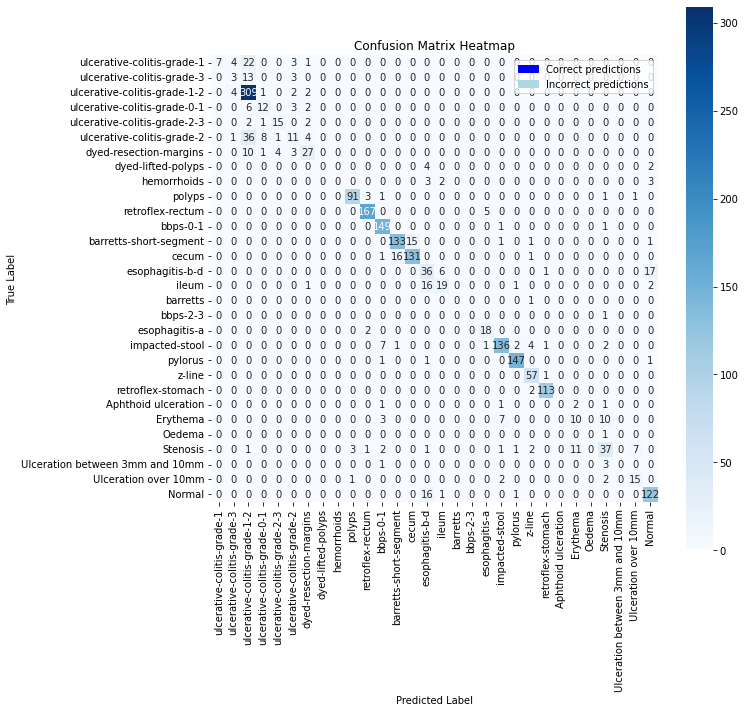

In [ ]:
# Calculate and print confusion matrix
cm = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:")
#print(cm)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, cbar=True, cbar_kws={'orientation': 'vertical'},
            xticklabels=['ulcerative-colitis-grade-1', 'ulcerative-colitis-grade-3', 'ulcerative-colitis-grade-1-2', 'ulcerative-colitis-grade-0-1',
               'ulcerative-colitis-grade-2-3', 'ulcerative-colitis-grade-2', 'dyed-resection-margins', 'dyed-lifted-polyps',
               'hemorrhoids', 'polyps', 'retroflex-rectum', 'bbps-0-1', 'barretts-short-segment', 'cecum',
               'esophagitis-b-d', 'ileum', 'barretts', 'bbps-2-3', 'esophagitis-a', 'impacted-stool', 'pylorus',
               'z-line', 'retroflex-stomach', 'Aphthoid ulceration', 'Erythema', 'Oedema', 'Stenosis',
               'Ulceration between 3mm and 10mm', 'Ulceration over 10mm', 'Normal'], 
            yticklabels=['ulcerative-colitis-grade-1', 'ulcerative-colitis-grade-3', 'ulcerative-colitis-grade-1-2', 'ulcerative-colitis-grade-0-1',
               'ulcerative-colitis-grade-2-3', 'ulcerative-colitis-grade-2', 'dyed-resection-margins', 'dyed-lifted-polyps',
               'hemorrhoids', 'polyps', 'retroflex-rectum', 'bbps-0-1', 'barretts-short-segment', 'cecum',
               'esophagitis-b-d', 'ileum', 'barretts', 'bbps-2-3', 'esophagitis-a', 'impacted-stool', 'pylorus',
               'z-line', 'retroflex-stomach', 'Aphthoid ulceration', 'Erythema', 'Oedema', 'Stenosis',
               'Ulceration between 3mm and 10mm', 'Ulceration over 10mm', 'Normal']) 
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')

# Create custom legend
blue_patch = mpatches.Patch(color='blue', label='Correct predictions')
light_blue_patch = mpatches.Patch(color='lightblue', label='Incorrect predictions')
plt.legend(handles=[blue_patch, light_blue_patch], loc='upper right')

plt.show()

In [ ]:
class_names = ['ulcerative-colitis-grade-1', 'ulcerative-colitis-grade-3', 'ulcerative-colitis-grade-1-2', 'ulcerative-colitis-grade-0-1',
               'ulcerative-colitis-grade-2-3', 'ulcerative-colitis-grade-2', 'dyed-resection-margins', 'dyed-lifted-polyps',
               'hemorrhoids', 'polyps', 'retroflex-rectum', 'bbps-0-1', 'barretts-short-segment', 'cecum',
               'esophagitis-b-d', 'ileum', 'barretts', 'bbps-2-3', 'esophagitis-a', 'impacted-stool', 'pylorus',
               'z-line', 'retroflex-stomach', 'Aphthoid ulceration', 'Erythema', 'Oedema', 'Stenosis',
               'Ulceration between 3mm and 10mm', 'Ulceration over 10mm', 'Normal']

# Calculate and print classification report
cr = classification_report(test_labels, test_preds, target_names=class_names)
print("Classification Report:")
print(cr)

Classification Report:
                                 precision    recall  f1-score   support

     ulcerative-colitis-grade-1       1.00      0.19      0.32        37
     ulcerative-colitis-grade-3       0.25      0.16      0.19        19
   ulcerative-colitis-grade-1-2       0.77      0.97      0.86       318
   ulcerative-colitis-grade-0-1       0.52      0.52      0.52        23
   ulcerative-colitis-grade-2-3       0.75      0.75      0.75        20
     ulcerative-colitis-grade-2       0.44      0.18      0.26        61
         dyed-resection-margins       0.69      0.60      0.64        45
             dyed-lifted-polyps       0.00      0.00      0.00         6
                    hemorrhoids       0.00      0.00      0.00         8
                         polyps       0.96      0.94      0.95        97
               retroflex-rectum       0.97      0.97      0.97       172
                       bbps-0-1       0.90      0.99      0.94       151
         barretts-short-seg

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Calculate and print accuracy score
acc = accuracy_score(test_labels, test_preds)
print("Accuracy Score: {:.2f}".format(acc))

Accuracy Score: 0.83


## calculate the macro-average ROC AUC score and weighted F1 score 

In [ ]:
# Binarize the labels
n_classes = len(class_names)
test_labels_bin = label_binarize(test_labels, classes=range(n_classes))



In [ ]:
batch_size = 32

# Calculate probabilities for each class
test_probs = np.zeros((len(test_labels), n_classes))
for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
    test_probs[i * batch_size:(i + 1) * batch_size] = probs

In [ ]:
# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

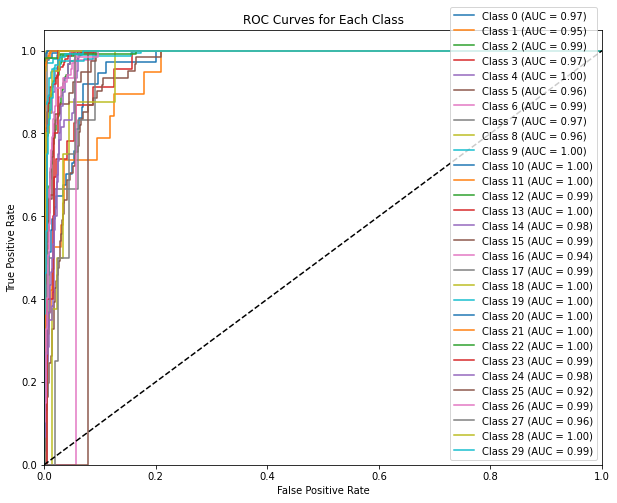

In [ ]:

# Visualize the ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Compute macro-average ROC AUC
roc_auc_macro = roc_auc_score(test_labels_bin, test_probs, average='macro')
print("Macro-average ROC AUC score: {:.2f}".format(roc_auc_macro))

Macro-average ROC AUC score: 0.98


In [ ]:
# Calculate and print weighted F1 score
f1_weighted = f1_score(test_labels, test_preds, average='weighted')
print("Weighted F1 score: {:.2f}".format(f1_weighted))

Weighted F1 score: 0.82


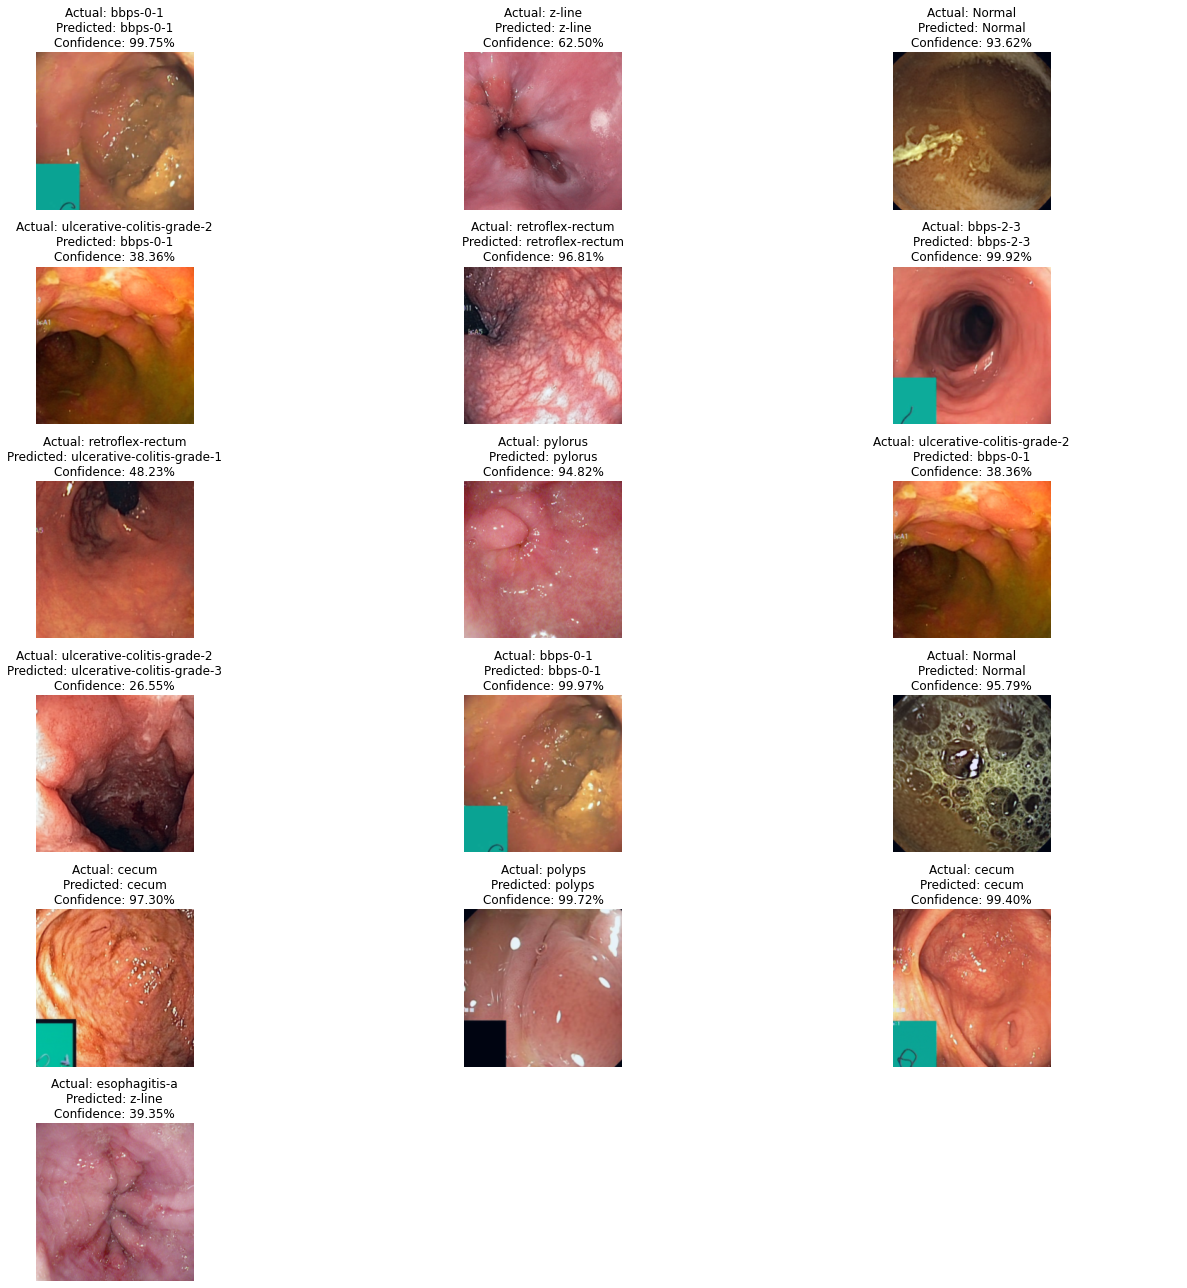

In [ ]:
# PREDICTIONS
# Define a function to plot a grid of images with labels, predicted labels, and confidence scores
def plot_prediction_grid(images, predicted_labels, confidence_scores, actual_labels, class_names, n_cols=3, figsize=(10, 10)):
    n_rows = len(images) // n_cols + 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18,18))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            image = images[i].cpu()
            predicted_label = predicted_labels[i]
            actual_label = actual_labels[i]
            label = class_names[predicted_label]
            confidence = confidence_scores[i] * 100
            image = (image - image.min()) / (image.max() - image.min())
            ax.imshow(image.permute(1, 2, 0))
            ax.set_title(f"Actual: {class_names[actual_label]}\nPredicted: {label}\nConfidence: {confidence:.2f}%")
        ax.axis("off")
    plt.tight_layout()

# Set the model to evaluation mode
model.eval()

# Select random images from the validation set
random_indices = torch.randint(len(val_dataset), size=(16,))
images = [val_dataset[i][0] for i in random_indices]
actual_labels = [val_dataset[i][1] for i in random_indices]

# Make predictions and compute confidence scores
with torch.no_grad():
    inputs = torch.stack(images).to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    predicted_labels = [p.item() for p in preds]
    confidence_scores = [np.exp(o[p].cpu()) / np.sum(np.exp(o.cpu().detach().numpy())) for o, p in zip(outputs, preds)]

plot_prediction_grid(inputs.cpu(), predicted_labels, confidence_scores, actual_labels, val_dataset.classes)
